1) Iterate over data directory: for each folder, get a "canonical" map size
2) With OSM fetcher, fetch maps, and store with file name = folder
3) Create CanonicalDataset:
    a) Create patches from OSM, store in a dict with key = directory, and value = list of patches
    b) For each patch in patch dataset, find directory and patch index
    c) Assign corresponding patches-osm patches

In [1]:
import sys
sys.path.append("../../py/")

In [88]:
from PIL import Image
import os
import requests
import logging
import pickle as pk

logger = logging.getLogger()
logger.setLevel(logging.INFO)

logging.basicConfig(format='%(asctime)s %(levelname)-4s %(message)s',
                    level=logging.INFO,
                    datefmt='%d-%m-%Y %H:%M:%S')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from shapely import wkt, geometry
from dotenv import load_dotenv

from torch.utils.data import Dataset

from map_patch import MapPatch

load_dotenv()

True

### Fetch OSM

In [11]:
def get_canonical_map_shape(map_directory):
    img_shapes = []
    for img_name in os.listdir(map_directory):
        if img_name.endswith(".png"):
            with Image.open(os.path.join(map_directory, img_name)) as img:
                img_shapes.append(list(img.size))
                            
    return np.round(np.mean(np.array(img_shapes), axis = 0)).astype(int)
            
def get_canonical_map_shapes(directory):
    map_shapes = {}
    for folder in os.listdir(directory):
        if folder.isdigit():
            map_shapes[int(folder)] = get_canonical_map_shape(os.path.join(directory, folder))
            
    return map_shapes

def get_meta(meta_dir):
    metadata = pd.read_csv(meta_dir)
    nunique = metadata.nunique()
    repeated_col_data = nunique[nunique == 1].index
    meta = metadata.drop(repeated_col_data, axis = 1, inplace = False)
    meta = meta[["IMAGE", "YEAR", "WKT"]]
    meta["WKT"] = meta["WKT"].apply(lambda x: wkt.loads(x).bounds)
    meta[["minx", "miny", "maxx", "maxy"]] = pd.DataFrame(meta["WKT"].tolist(), index = meta.index)
    meta.drop("WKT", axis = 1, inplace = True)
    
    return meta

def get_map_bbox(map_name, meta):
    map_data = meta[meta["IMAGE"] == int(map_name)]
    minx, miny, maxx, maxy = map_data.loc[:, ["minx", "miny", "maxx", "maxy"]].values[0]
    
    return minx, miny, maxx, maxy

def fetch_canonical_map(width, height, minx, miny, maxx, maxy, style = "osm-carto"):
    geoapify_url = "https://maps.geoapify.com/v1/staticmap"
    geoapify_request_dict = {"apiKey" : os.environ["GEOAPIFY_KEY"],
                             "style" : style,
                             "area" : f"rect:{minx},{miny},{maxx},{maxy}",
                             "height" : height, 
                             "width" : width,
                             "scaleFactor" : 1
                            }

    response = requests.get(geoapify_url, params = geoapify_request_dict)
    
    return response.content

def get_canonical_osm_map(directory, osm_save_dir, meta, debug = False, style = "osm-carto"):
    map_shapes = {}
    
    if not os.path.isdir(osm_save_dir):
        os.mkdir(osm_save_dir)
        
    logging.info(f"Saving maps in {osm_save_dir}, using style {style}")
        
    dir_list = os.listdir(directory)
    
    for folder in dir_list:
        if folder.isdigit():
            logging.info(f"Processing folder: {folder}")
            canonical_map_shape = get_canonical_map_shape(os.path.join(directory, folder))
            map_shapes[int(folder)] = canonical_map_shape
            example_map_name = [map_name for map_name in os.listdir(os.path.join(directory, folder)) if map_name.endswith(".png")][0]
            example_map_name = example_map_name[:example_map_name.index(".")]
            
            width, height = canonical_map_shape
            minx, miny, maxx, maxy = get_map_bbox(example_map_name, meta)
            
            canonical_map = fetch_canonical_map(width, height, minx, miny, maxx, maxy, style)
            
            with open(os.path.join(osm_save_dir, f"{folder}.png"), "wb") as map_dir:
                map_dir.write(canonical_map)
                      
            if debug:
                return map_shapes
                      
            
    return map_shapes


In [12]:
canonical_map_shapes = get_canonical_map_shapes("../../data/originals/")

In [13]:
meta = get_meta("../../../os_meta.csv")
meta

,IMAGE,YEAR,minx,miny,maxx,maxy
0,82877892,1894,-3.305799,55.886052,-3.267098,55.900605
1,82877928,1894,-3.190029,55.886313,-3.151372,55.900830
2,82877940,1894,-3.305674,55.871598,-3.266988,55.886151
3,82877949,1894,-3.267098,55.871697,-3.228427,55.886238
4,82877958,1894,-3.228523,55.871785,-3.189866,55.886313
...,...,...,...,...,...,...
207,82878021,1934,-3.151507,55.900830,-3.112850,55.915335
208,82878033,1934,-3.112903,55.900881,-3.074261,55.915374
209,82878063,1934,-3.151439,55.886376,-3.112798,55.900881
210,82878075,1934,-3.112850,55.886427,-3.074222,55.900920


In [14]:
canonical_map_shapes = get_canonical_osm_map(directory = "../../data/originals/",
                                   osm_save_dir = "../../data/originals/osm_carto/",
                                   meta = meta,
                                   debug = False,
                                   style = "osm-carto")

24-02-2023 15:17:45 INFO Saving maps in ../../data/originals/osm_carto/, using style osm-carto
24-02-2023 15:17:45 INFO Processing folder: 50
24-02-2023 15:17:50 INFO Processing folder: 57
24-02-2023 15:17:50 INFO Processing folder: 32
24-02-2023 15:18:17 INFO Processing folder: 35
24-02-2023 15:18:55 INFO Processing folder: 56
24-02-2023 15:19:09 INFO Processing folder: 51
24-02-2023 15:19:23 INFO Processing folder: 34
24-02-2023 15:19:45 INFO Processing folder: 33
24-02-2023 15:19:57 INFO Processing folder: 20
24-02-2023 15:20:30 INFO Processing folder: 18
24-02-2023 15:20:45 INFO Processing folder: 9
24-02-2023 15:21:00 INFO Processing folder: 7
24-02-2023 15:21:20 INFO Processing folder: 29
24-02-2023 15:21:47 INFO Processing folder: 16
24-02-2023 15:21:59 INFO Processing folder: 42
24-02-2023 15:22:17 INFO Processing folder: 45
24-02-2023 15:22:37 INFO Processing folder: 6
24-02-2023 15:23:01 INFO Processing folder: 17
24-02-2023 15:23:10 INFO Processing folder: 1
24-02-2023 15:23

In [15]:
canonical_map_shapes_bright = get_canonical_osm_map(directory = "../../data/originals/",
                                   osm_save_dir = "../../data/originals/osm_bright/",
                                   meta = meta,
                                   debug = False,
                                   style = "osm-bright")

24-02-2023 15:33:52 INFO Saving maps in ../../data/originals/osm_bright/, using style osm-bright
24-02-2023 15:33:52 INFO Processing folder: 50
24-02-2023 15:34:03 INFO Processing folder: 57
24-02-2023 15:34:08 INFO Processing folder: 32
24-02-2023 15:34:28 INFO Processing folder: 35
24-02-2023 15:34:37 INFO Processing folder: 56
24-02-2023 15:34:43 INFO Processing folder: 51
24-02-2023 15:34:50 INFO Processing folder: 34
24-02-2023 15:35:05 INFO Processing folder: 33
24-02-2023 15:35:24 INFO Processing folder: 20
24-02-2023 15:35:29 INFO Processing folder: 18
24-02-2023 15:35:47 INFO Processing folder: 9
24-02-2023 15:36:02 INFO Processing folder: 7
24-02-2023 15:36:12 INFO Processing folder: 29
24-02-2023 15:36:27 INFO Processing folder: 16
24-02-2023 15:36:44 INFO Processing folder: 42
24-02-2023 15:36:49 INFO Processing folder: 45
24-02-2023 15:36:54 INFO Processing folder: 6
24-02-2023 15:37:03 INFO Processing folder: 17
24-02-2023 15:37:20 INFO Processing folder: 1
24-02-2023 15:

### Create Canonical Datasets

In [72]:
class CanonicalDataset(Dataset):
    def __init__(self, historical_patches, osm_patches):
        self.historical_patches = historical_patches
        self.osm_patches = osm_patches
    
    def __len__(self):
        return len(self.historical_patches)
    
    def __getitem__(self, i):

        if isinstance(i, slice):
            start = i.start if i.start else 0
            stop = i.stop if i.stop else len(self.X_1)
            step = i.step if i.step else 1

            return [(self.historical_patches[j].patch, self.osm_patches[j].patch) for j in range(start, stop, step)]

        return (self.historical_patches[i].patch, self.osm_patches[i].patch)
    
    def get(self, i):
        if isinstance(i, slice):
            start = i.start if i.start else 0
            stop = i.stop if i.stop else len(self.X_1)
            step = i.step if i.step else 1

            return [(self.historical_patches[j], self.osm_patches[j]) for j in range(start, stop, step)]

        return (self.historical_patches[i], self.osm_patches[i])
    
    @staticmethod
    def get_folder(patch):
        map_dir = patch.origin_map
        dir_path = os.path.dirname(map_dir)

        # Split the directory path into a list of subdirectories
        subdirs = dir_path.split(os.path.sep)

        # Retrieve the last subdirectory
        return int(subdirs[-1])
    
    @staticmethod
    def get_osm_patch_dict(osm_maps_dir, patch_width):
        
        osm_patch_dict = {}
        
        for img in os.listdir(osm_maps_dir):
            dot_index = img.index(".")
            folder_number = img[:dot_index]
            if folder_number.isdigit():
                osm_patch_list = MapPatch.get_map_patch_list(file_name = os.path.join(osm_maps_dir, img), 
                                                    patch_width = patch_width, 
                                                    verbose = False)
                osm_patch_dict[int(folder_number)] = osm_patch_list
                
        return osm_patch_dict
                
    
    @classmethod
    def from_dir(cls, patch_dataset_dir, osm_maps_dir, debug = False):
        patch_dataset = None
        
        logging.info(f"Fetching original patch dataset from {patch_dataset_dir}")
        with open(patch_dataset_dir, "rb") as f:
            patch_dataset = pk.load(f)
            
        historical_patches = []
        osm_patches = []
        
        patch_width = patch_dataset.X_1[0].patch.shape[0]
        logging.info(f"Creating dictionary for OSM patches, with patch width = {patch_width}")
        osm_patch_dict = CanonicalDataset.get_osm_patch_dict(osm_maps_dir, patch_width)
        
        n_cols = osm_patch_dict[1][-1].patch_index[1] + 1
        
        iter_range = 100 if debug else len(patch_dataset.X_1)
        
        logging.info(f"Matching historical patches with OSM patches ({iter_range} iterations)")
        for i in range(iter_range):
            historical_patch_1 = patch_dataset.X_1[i]
            historical_patch_2 = patch_dataset.X_2[i]
            
            patch_index = historical_patch_1.patch_index
            
            osm_map_name = CanonicalDataset.get_folder(historical_patch_1)
            osm_map_patches = osm_patch_dict[osm_map_name]
            
            osm_patch = osm_map_patches[patch_index[0] * n_cols + patch_index[1]]
            
            assert osm_patch.patch_index == patch_index
            
            historical_patches.extend([historical_patch_1, historical_patch_2])
            osm_patches.extend([osm_patch, osm_patch])
            
        return cls(historical_patches, osm_patches)
    
    def save(self, file_name):
        with open(file_name, "wb") as f:
            if file_name.endswith(".pt"):
                torch.save(self, f)
            else:
                pk.dump(self, f)

In [66]:
with open("../../py/output/patch_train_dataset_128.pk", "rb") as f:
    patch_train_dataset = pk.load(f)
    
with open("../../py/output/patch_val_dataset_128.pk", "rb") as f:
    patch_val_dataset = pk.load(f)

In [103]:
canonical_train_dataset = CanonicalDataset.from_dir(patch_dataset_dir = "../../py/output/patch_train_dataset_128.pk",
                                                  osm_maps_dir = "../../data/originals/osm_carto/")

25-02-2023 12:39:27 INFO Fetching original patch dataset from ../../py/output/patch_train_dataset_128.pk
25-02-2023 12:40:09 INFO Creating dictionary for OSM patches, with patch width = 128
25-02-2023 12:40:39 INFO Matching historical patches with OSM patches (110103 iterations)


In [73]:
canonical_val_dataset = CanonicalDataset.from_dir(patch_dataset_dir = "../../py/output/patch_val_dataset_128.pk",
                                                  osm_maps_dir = "../../data/originals/osm_carto/")

25-02-2023 12:27:39 INFO Fetching original patch dataset from ../../py/output/patch_val_dataset_128.pk
25-02-2023 12:27:40 INFO Creating dictionary for OSM patches, with patch width = 128
25-02-2023 12:27:52 INFO Matching historical patches with OSM patches (2247 iterations)


In [86]:
canonical_val_dataset_bright = CanonicalDataset.from_dir(patch_dataset_dir = "../../py/output/patch_val_dataset_128.pk",
                                                  osm_maps_dir = "../../data/originals/osm_bright/")

25-02-2023 12:32:12 INFO Fetching original patch dataset from ../../py/output/patch_val_dataset_128.pk
25-02-2023 12:32:15 INFO Creating dictionary for OSM patches, with patch width = 128
25-02-2023 12:32:29 INFO Matching historical patches with OSM patches (2247 iterations)


480


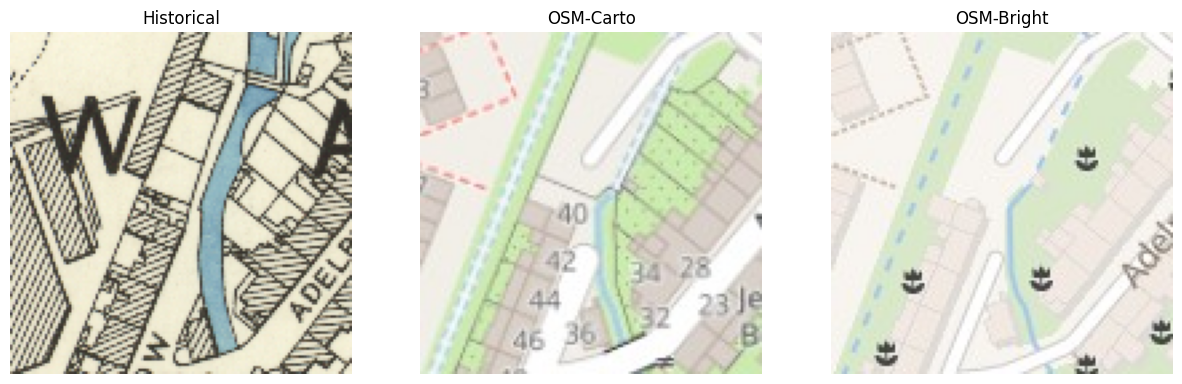

In [101]:
i = np.random.randint(0,len(canonical_val_dataset))
print(i)
patch_1_carto, patch_2_carto = canonical_val_dataset[i]
historical_2, carto_1 = canonical_val_dataset[i]
patch_1_bright, patch_2_bright = canonical_val_dataset_bright[i]

fig, ax = plt.subplots(1, 3, figsize = (15,5))
ax[0].imshow(patch_1_carto)
ax[0].set_title("Historical")
ax[1].imshow(patch_2_carto)
ax[1].set_title("OSM-Carto")
ax[2].imshow(patch_2_bright)
ax[2].set_title("OSM-Bright")

for ax_ in ax:
    ax_.axis("off")

plt.show()

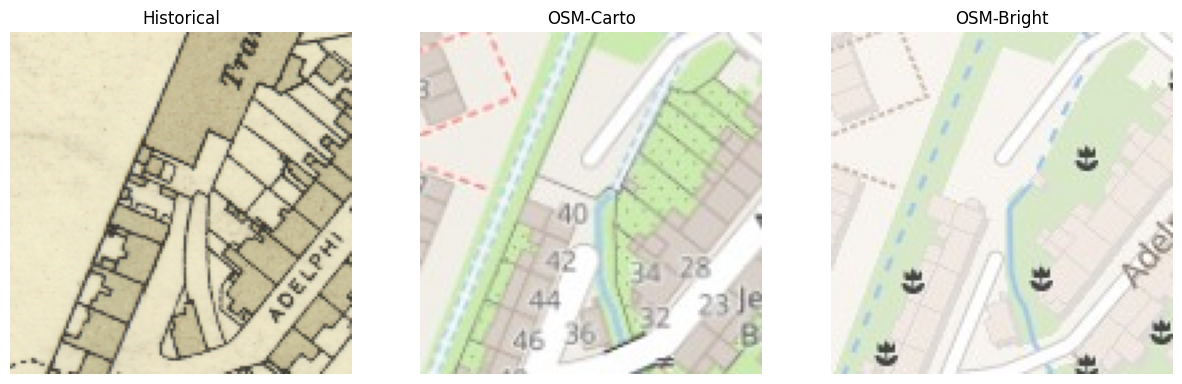

In [102]:
patch_1_carto, patch_2_carto = canonical_val_dataset[i+1]
historical_2, carto_1 = canonical_val_dataset[i+1]
patch_1_bright, patch_2_bright = canonical_val_dataset_bright[i+1]

fig, ax = plt.subplots(1, 3, figsize = (15,5))
ax[0].imshow(patch_1_carto)
ax[0].set_title("Historical")
ax[1].imshow(patch_2_carto)
ax[1].set_title("OSM-Carto")
ax[2].imshow(patch_2_bright)
ax[2].set_title("OSM-Bright")

for ax_ in ax:
    ax_.axis("off")

plt.show()

### Experimenting

In [12]:
test_patch = patch_train_dataset.X_1[np.random.randint(0,len(patch_train_dataset.X_1))]
print(test_patch.origin_map)
print(CanonicalDataset.get_folder(test_patch))

/disk/scratch_big/s1908368/data/9/82877574.png
9


In [55]:
osm_patch_dict = CanonicalDataset.get_osm_patch_dict(osm_maps_dir = "../../data/originals/osm_carto/",
                                                     patch_width = 128)

25-02-2023 12:16:05 INFO 551 patches from ../../data/originals/osm_carto/48.png generated with shape (19, 29, 1, 128, 128, 3)
25-02-2023 12:16:05 INFO 551 patches from ../../data/originals/osm_carto/49.png generated with shape (19, 29, 1, 128, 128, 3)
25-02-2023 12:16:06 INFO 551 patches from ../../data/originals/osm_carto/8.png generated with shape (19, 29, 1, 128, 128, 3)
25-02-2023 12:16:06 INFO 551 patches from ../../data/originals/osm_carto/9.png generated with shape (19, 29, 1, 128, 128, 3)
25-02-2023 12:16:06 INFO 551 patches from ../../data/originals/osm_carto/14.png generated with shape (19, 29, 1, 128, 128, 3)
25-02-2023 12:16:06 INFO 551 patches from ../../data/originals/osm_carto/29.png generated with shape (19, 29, 1, 128, 128, 3)
25-02-2023 12:16:07 INFO 551 patches from ../../data/originals/osm_carto/15.png generated with shape (19, 29, 1, 128, 128, 3)
25-02-2023 12:16:07 INFO 551 patches from ../../data/originals/osm_carto/17.png generated with shape (19, 29, 1, 128, 12

In [58]:
osm_patch_dict.keys()

dict_keys([48, 49, 8, 9, 14, 29, 15, 17, 16, 12, 13, 39, 10, 38, 35, 21, 20, 34, 22, 36, 37, 23, 33, 32, 26, 18, 30, 24, 25, 31, 19, 4, 56, 42, 43, 5, 57, 41, 55, 7, 54, 6, 40, 44, 2, 50, 3, 51, 45, 53, 1, 47, 46, 52])

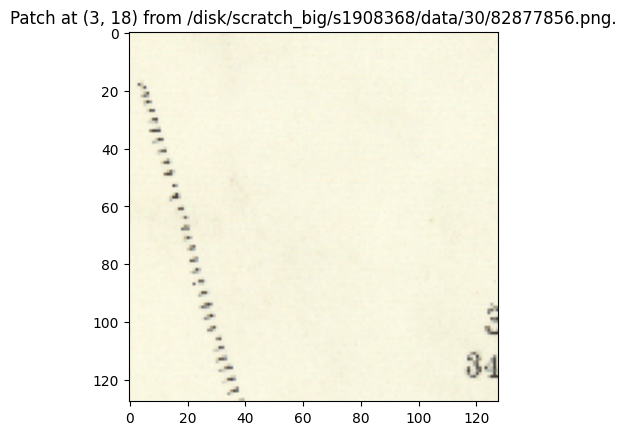

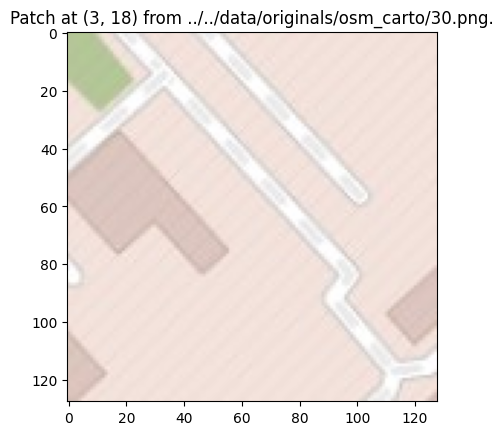

In [42]:
patch_train_dataset.X_1[798].show()
osm_patch_dict["30"][3 * 29 + 18].show()

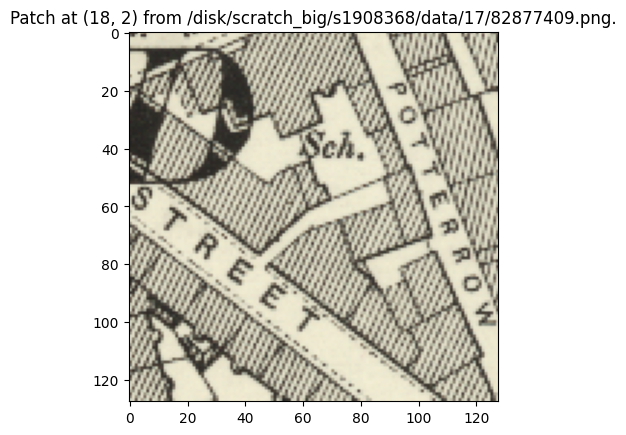

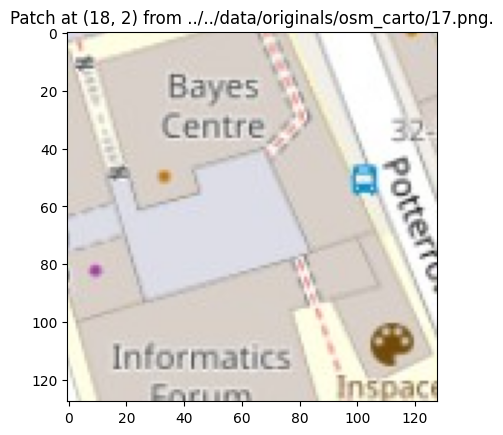

In [44]:
patch_train_dataset.X_1[800].show()
osm_patch_dict["17"][18 * 29 + 2].show()